### Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from fastai import *
from fastai.vision import *
from fastai.callbacks import *

np.random.seed(42)
torch.cuda.set_device(0)

from annoy import AnnoyIndex

import glob

In [ ]:
pip install annoy

     |████████████████████████████████| 646 kB 9.0 MB/s 
  Created wheel for annoy: filename=annoy-1.17.0-cp37-cp37m-linux_x86_64.whl size=391670 sha256=7b0c7eb44ce5e82f8c7e76028ffe0b8bdd8e9e111ab3b2d96fa82675475fbb6d
  Stored in directory: /root/.cache/pip/wheels/4f/e8/1e/7cc9ebbfa87a3b9f8ba79408d4d31831d67eea918b679a4c07
Successfully built annoy


In [ ]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Creating DFs

In [ ]:
#creating df of image names & dataset label (train, val, test)
img_partitions = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FashionRecommendations/CNN/example/list_eval_partition.txt', 
                             delim_whitespace=True, header=1)

#creating df of attribute names and type label
attributes = pd.read_csv(
    '/content/drive/MyDrive/Colab Notebooks/FashionRecommendations/CNN/example/list_attr_cloth (1).txt', 
    sep='\s{2,}', 
    header=0, 
    skiprows=[0], 
    engine='python')

attributes_imgs = pd.read_csv(
    '/content/drive/MyDrive/Colab Notebooks/FashionRecommendations/CNN/example/list_attr_img.txt', 
    delim_whitespace=True, 
    header=0,
    skiprows=[0],
    names=(['image_name'] + attributes['attribute_name'].tolist()))
attributes_imgs.replace([-1,0,1],[False,False,True], inplace=True)

#creating df of image names, attribute tags, and dataset label
attributes_df = attributes_imgs.merge(img_partitions, how ='left', on='image_name')
attributes_df

image_name  a-line  abstract  \
0         img/Sheer_Pleated-Front_Blouse/img_00000001.jpg   False     False   
1         img/Sheer_Pleated-Front_Blouse/img_00000002.jpg   False     False   
2         img/Sheer_Pleated-Front_Blouse/img_00000003.jpg   False     False   
3         img/Sheer_Pleated-Front_Blouse/img_00000004.jpg   False     False   
4         img/Sheer_Pleated-Front_Blouse/img_00000005.jpg   False     False   
...                                                   ...     ...       ...   
289217  img/Paisley_Print_Babydoll_Dress/img_00000050.jpg   False     False   
289218  img/Paisley_Print_Babydoll_Dress/img_00000051.jpg   False     False   
289219  img/Paisley_Print_Babydoll_Dress/img_00000052.jpg   False     False   
289220  img/Paisley_Print_Babydoll_Dress/img_00000053.jpg   False     False   
289221  img/Paisley_Print_Babydoll_Dress/img_00000054.jpg   False     False   

        abstract chevron  abstract chevron print  abstract diamond  \
0                  False                   False             False   
1                  False                   False             False   
2                  False                   False             False   
3                  False                   False             False   
4                  False                   False             False   
...                  ...                     ...               ...   
289217             False                   False             False   
289218             False                   False             False   
289219             False                   False             False   
289220             False                   False             False   
289221             False                   False             False   

        abstract floral  abstract floral print  abstract geo  \
0                 False                  False         False   
1                 False                  False         False   
2                 False                  False         False   
3                 False                  False         False   
4                 False                  False         False   
...                 ...                    ...           ...   
289217            False                  False         False   
289218            False                  False         False   
289219            False                  False         False   
289220            False                  False         False   
289221            False                  False         False   

        abstract geo print  abstract paisley  abstract pattern  \
0                    False             False             False   
1                    False             False             False   
2                    False             False             False   
3                    False             False             False   
4                    False             False             False   
...                    ...               ...               ...   
289217               False             False             False   
289218               False             False             False   
289219               False             False             False   
289220               False             False             False   
289221               False             False             False   

        abstract print  abstract printed  abstract stripe   acid  acid wash  \
0                False             False            False  False      False   
1                False             False            False  False      False   
2                False             False            False  False      False   
3                False             False            False  False      False   
4                False             False            False  False      False   
...                ...               ...              ...    ...        ...   
289217           False             False            False  False      False   
289218           False             False            False  Fals

In [ ]:
#create list of column names to keep for training
# 1 = Texture, 2 = Fabric, 3 = Shape, 4 = Parts, 5 = Style
list_attr_names = ['image_name']+attributes[(attributes['attribute_type']==2)]['attribute_name'].tolist()
training_df = attributes_df[attributes_df['evaluation_status'].isin(['train','val'])][list_attr_names].copy()
training_df.reset_index(drop=True, inplace=True)
training_df

,image_name,acid,acid wash,applique,bead,beaded,beaded chiffon,beaded sheer,bejeweled,bleach,bleached,bleached denim,brocade,burnout,cable,cable knit,cable-knit,canvas,chambray,chambray drawstring,chenille,chiffon,chiffon lace,chiffon layered,chiffon shirt,chino,chunky,chunky knit,classic cotton,classic denim,classic knit,classic woven,clean,clean wash,cloud,cloud wash,coated,corduroy,cotton,cotton drawstring,cotton knit,cotton-blend,crepe,crepe woven,crinkled,crochet,crochet embroidered,crochet knit,crochet lace,crochet mesh,crochet overlay,crocheted,crocheted lace,cuffed denim,cutout lace,damask,denim,denim drawstring,denim shirt,denim utility,dip-dye,dip-dyed,distressed,dye,elasticized,embellished,embroidered,embroidered gauze,embroidered lace,embroidered mesh,embroidered woven,embroidery,eyelash,eyelash knit,eyelash lace,eyelet,faded,fair,fair isle,faux,faux fur,faux leather,faux shearling,faux suede,feather,floral knit,floral lace,floral mesh,foulard,frayed,french,french terry,fur,fuzzy,fuzzy knit,gauze,gauzy,gem,georgette,gingham,glass,glitter,heathered,heathered knit,herringbone,jacquard,knit,knit lace,lace,lace layered,lace mesh,lace overlay,lace panel,lace paneled,lace pleated,lace print,lace sheer,lace-paneled,lacy,lattice,layered,leather,leather paneled,leather quilted,leather-paneled,led,loop,loose,loose-knit,mesh,mesh overlay,mesh panel,mesh paneled,mesh-paneled,metallic,mineral,mineral wash,neon,neoprene,nets,netted,nylon,oil,organza,origami,overlay,panel,paneled,patched,patchwork,perforated,pima,pintuck,pintuck pleated,pintucked,plaid,plaid shirt,pleat,pleated,pleated woven,pointelle,ponte,print satin,print scuba,purl,quilted,rhinestone,rib,rib-knit,ribbed,ribbed-knit,ripped,ruched,ruffle,ruffled,sateen,satin,scuba,seam,seamless,seersucker,semi-sheer,sequin,sequined,shaggy,shearling,sheer,sheer-paneled,shirred,shredded,sleek,slick,slub,slub-knit,sparkling,stone,stone washed,stones,stretch,stretch-knit,studded,suede,tapestry,tartan,terry,textured,textured woven,tie-dye,tiered,tile,tulle,tweed,twill,velvet,velveteen,waffle,wash,washed,woven
0,img/Sheer_Pleated-Front_Blouse/img_00000001.jpg,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,img/Sheer_Pleated-Front_Blouse/img_00000002.jpg,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,

In [ ]:
#removing images from DF with no label
training_df['max'] = [training_df.iloc[x][1:].max() for x in training_df.index.tolist()]
training_df = training_df[training_df['max'].isin([True])].copy()
training_df.drop('max', axis=1, inplace=True)
training_df

IndexError: ignored

In [ ]:
def count_attr_imgs(attr_df):
    col_counts = {}

    for col in attr_df.columns[1:]:
        col_counts[col] = attr_df[col].value_counts().to_frame().loc[True][0]
    
    col_df = pd.DataFrame.from_dict(col_counts, orient='index', columns=['Count'])
    
    return col_df
training_df
#.sort_values(by='Count')

,image_name,acid,acid wash,applique,bead,beaded,beaded chiffon,beaded sheer,bejeweled,bleach,bleached,bleached denim,brocade,burnout,cable,cable knit,cable-knit,canvas,chambray,chambray drawstring,chenille,chiffon,chiffon lace,chiffon layered,chiffon shirt,chino,chunky,chunky knit,classic cotton,classic denim,classic knit,classic woven,clean,clean wash,cloud,cloud wash,coated,corduroy,cotton,cotton drawstring,cotton knit,cotton-blend,crepe,crepe woven,crinkled,crochet,crochet embroidered,crochet knit,crochet lace,crochet mesh,crochet overlay,crocheted,crocheted lace,cuffed denim,cutout lace,damask,denim,denim drawstring,denim shirt,denim utility,dip-dye,dip-dyed,distressed,dye,elasticized,embellished,embroidered,embroidered gauze,embroidered lace,embroidered mesh,embroidered woven,embroidery,eyelash,eyelash knit,eyelash lace,eyelet,faded,fair,fair isle,faux,faux fur,faux leather,faux shearling,faux suede,feather,floral knit,floral lace,floral mesh,foulard,frayed,french,french terry,fur,fuzzy,fuzzy knit,gauze,gauzy,gem,georgette,gingham,glass,glitter,heathered,heathered knit,herringbone,jacquard,knit,knit lace,lace,lace layered,lace mesh,lace overlay,lace panel,lace paneled,lace pleated,lace print,lace sheer,lace-paneled,lacy,lattice,layered,leather,leather paneled,leather quilted,leather-paneled,led,loop,loose,loose-knit,mesh,mesh overlay,mesh panel,mesh paneled,mesh-paneled,metallic,mineral,mineral wash,neon,neoprene,nets,netted,nylon,oil,organza,origami,overlay,panel,paneled,patched,patchwork,perforated,pima,pintuck,pintuck pleated,pintucked,plaid,plaid shirt,pleat,pleated,pleated woven,pointelle,ponte,print satin,print scuba,purl,quilted,rhinestone,rib,rib-knit,ribbed,ribbed-knit,ripped,ruched,ruffle,ruffled,sateen,satin,scuba,seam,seamless,seersucker,semi-sheer,sequin,sequined,shaggy,shearling,sheer,sheer-paneled,shirred,shredded,sleek,slick,slub,slub-knit,sparkling,stone,stone washed,stones,stretch,stretch-knit,studded,suede,tapestry,tartan,terry,textured,textured woven,tie-dye,tiered,tile,tulle,tweed,twill,velvet,velveteen,waffle,wash,washed,woven
0,img/Sheer_Pleated-Front_Blouse/img_00000001.jpg,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,img/Sheer_Pleated-Front_Blouse/img_00000002.jpg,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,

## Baseline Model (No Data Cleaning)

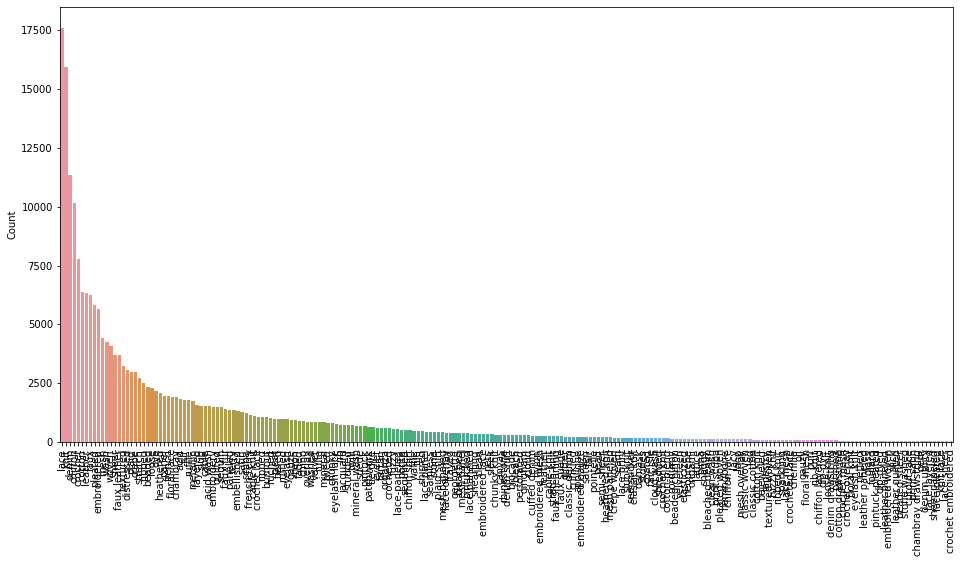

In [ ]:
plt.figure(figsize=(16,8))
sns.barplot(x=count_attr_imgs(training_df).sort_values(by='Count',ascending=False).index,y=count_attr_imgs(training_df).sort_values(by='Count',ascending=False)['Count'])
plt.xticks(rotation=90);

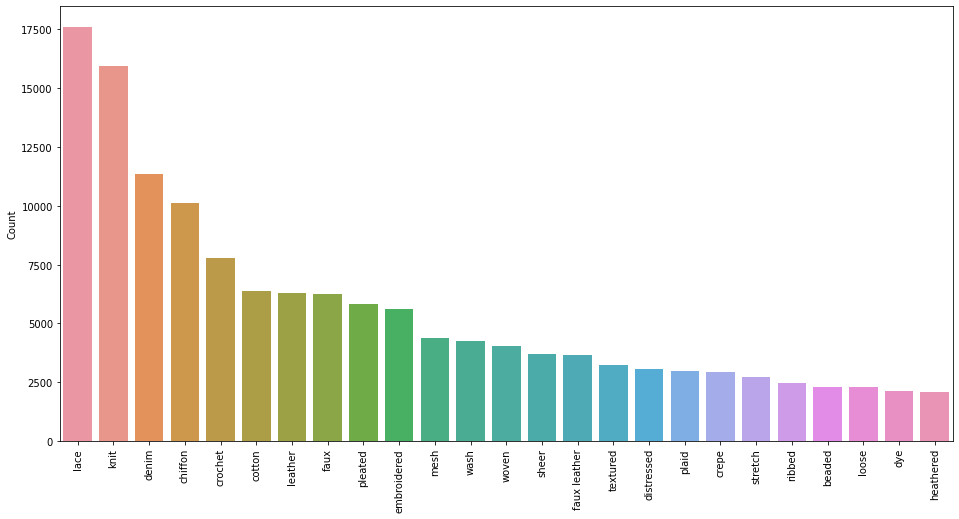

In [ ]:
plt.figure(figsize=(16,8))
sns.barplot(x=count_attr_imgs(training_df).sort_values(by='Count',ascending=False)[:25].index,y=count_attr_imgs(training_df).sort_values(by='Count',ascending=False)[:25]['Count'])
plt.xticks(rotation=90);

In [ ]:
from fastai import *
from fastai.vision import *

np.random.seed(42)
torch.cuda.set_device(0)

In [ ]:
# take all the columns after the first "image_name" col
label_column_names = training_df.columns.tolist()[1:]
label_column_names

img_base_path = Path("./Img/")
data = ImageDataBunch.from_df(img_base_path, training_df, ds_tfms=get_transforms(), size=150, label_col=label_column_names)
data.normalize(imagenet_stats)

['acid',
 'acid wash',
 'applique',
 'bead',
 'beaded',
 'beaded chiffon',
 'beaded sheer',
 'bejeweled',
 'bleach',
 'bleached',
 'bleached denim',
 'brocade',
 'burnout',
 'cable',
 'cable knit',
 'cable-knit',
 'canvas',
 'chambray',
 'chambray drawstring',
 'chenille',
 'chiffon',
 'chiffon lace',
 'chiffon layered',
 'chiffon shirt',
 'chino',
 'chunky',
 'chunky knit',
 'classic cotton',
 'classic denim',
 'classic knit',
 'classic woven',
 'clean',
 'clean wash',
 'cloud',
 'cloud wash',
 'coated',
 'corduroy',
 'cotton',
 'cotton drawstring',
 'cotton knit',
 'cotton-blend',
 'crepe',
 'crepe woven',
 'crinkled',
 'crochet',
 'crochet embroidered',
 'crochet knit',
 'crochet lace',
 'crochet mesh',
 'crochet overlay',
 'crocheted',
 'crocheted lace',
 'cuffed denim',
 'cutout lace',
 'damask',
 'denim',
 'denim drawstring',
 'denim shirt',
 'denim utility',
 'dip-dye',
 'dip-dyed',
 'distressed',
 'dye',
 'elasticized',
 'embellished',
 'embroidered',
 'embroidered gauze',
 'em

In [ ]:
data.show_batch(rows=4, figsize=(14,12))

In [ ]:
print(data.classes)
len(data.classes),data.c


In [ ]:
acc_02 = partial(accuracy_thresh, thresh=0.1)
f_score = partial(fbeta, thresh=0.1)

In [ ]:
learn = cnn_learner(data, models.resnet50, metrics=[acc_02, f_score], callback_fns=ShowGraph)

In [ ]:
learn.fit_one_cycle(5)

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(4, slice(1e-5,1e-3))

In [ ]:
learn.save('fabric-resnet50-size150-fr5-unfr4', return_path=True)
learn.export('fabric-resnet50-size150-fr5-unfr4.pkl')

In [ ]:
learn = load_learner('Img/','fabric-resnet50-size150-fr5-unfr4.pkl')

In [ ]:
predict_img_path = "pink.jpg" 
category,classIndex,losses = learn.predict(open_image(predict_img_path))
predictions = sorted(zip(data.classes, map(float, losses)), key=lambda p: p[1], reverse=True)
print (predictions[:5])
show_image(open_image(predict_img_path))

# "/data/Michael/data/predict/2.png"